In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*

filename = "params_dr.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
k_id, w_id, patch_diameter = itemgetter("k_id", "w_id", "patch_diameter")(params["stimulus"])
A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])

wavenumber_tuning = {"fb_ex": {}, "fb_in": {}, "fb_mix": {}}

## Feedback excitation

In [ ]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(dr), len(w_rc_ex), len(k_id)])
    
    for j, dx in enumerate(dr):
        for i, w in enumerate(w_rc_ex):
            network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dx,
                                     A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                     w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                     w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                     w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex)

            angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
            wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
            spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                     angular_freq=angular_freq,
                                                                     wavenumber=wavenumber,
                                                                     patch_diameter=d)

            tuning_curve[j, i, :] = spatiotemporal_tuning[0, :]

    wavenumber_tuning["fb_ex"][float(d.magnitude)] = tuning_curve

## Feedback inhibition

In [ ]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(dr), len(w_rc_in), len(k_id)])   
    
    for j, dx in enumerate(dr):
        for i, w in enumerate(w_rc_in):
            network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dx,
                                     A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                     w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                     w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                     w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in)

            angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
            wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
            spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                     angular_freq=angular_freq,
                                                                     wavenumber=wavenumber,
                                                                     patch_diameter=d)

            tuning_curve[j, i, :] = spatiotemporal_tuning[0, :]
        
    wavenumber_tuning["fb_in"][float(d.magnitude)] = tuning_curve

## Mixed excitatory and inhibitory feedback

In [ ]:
for d in patch_diameter:
    tuning_curve = np.zeros([len(dr), len(w_rc_mix), len(k_id)])
    
    for j, dx in enumerate(dr):
        for i, w in enumerate(w_rc_mix):
            network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dx,
                                     A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                     w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                     w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                     w_rc_in=w, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                                     w_rc_ex=w, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex)

            angular_freq = network.integrator.temporal_angular_freqs[int(w_id)]
            wavenumber = network.integrator.spatial_angular_freqs[k_id.astype(int)]
            spatiotemporal_tuning = spatiotemporal_wavenumber_tuning(network=network,
                                                                     angular_freq=angular_freq,
                                                                     wavenumber=wavenumber,
                                                                     patch_diameter=d)

            tuning_curve[j, i, :] = spatiotemporal_tuning[0, :]


    wavenumber_tuning["fb_mix"][float(d.magnitude)] = tuning_curve

-------------
## Convergence plots

<IPython.core.display.Javascript object>


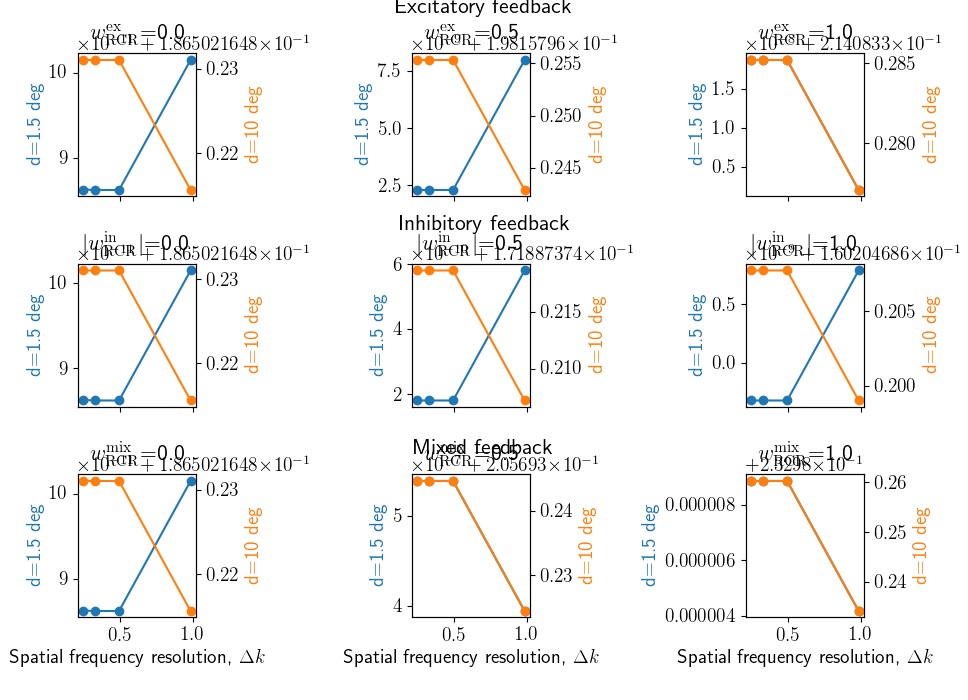

In [6]:
def map_wavenumber(tuning, j, dr):
    k_id = 3
    
    if k_id == 0:
        map_factors = np.zeros(len(dr), dtype=int)
    else:
        map_factors = (k_id + np.arange(0, 4*k_id, k_id)).astype(int)
    res = np.zeros(len(dr))
    
    for i, k in enumerate(map_factors):
        res[i] = tuning[i, j, k]
    return res

dk = 2*np.pi/2**nr/dr
titles = ["Excitatory feedback", "Inhibitory feedback", "Mixed feedback"]
labels = [r"$w^\mathrm{ex}_{\mathrm{RCR}}$", r"$|w^\mathrm{in}_{\mathrm{RCR}}|$", 
          r"$w^\mathrm{mix}_{\mathrm{RCR}}$"]

fig, axarr = plt.subplots(3, 3, figsize=(9, 6), sharex="all")
plt.figtext(0.5, 0.99, titles[0], ha='center', va='center', fontsize=16)
plt.figtext(0.5, 0.68, titles[1], ha='center', va='center', fontsize=16)
plt.figtext(0.5, 0.36, titles[2], ha='center', va='center', fontsize=16)
plt.subplots_adjust(hspace=2)


for i, (key, w_rc) in enumerate(zip(wavenumber_tuning.keys(), [w_rc_ex, w_rc_in, w_rc_mix])):
    ax = axarr[i, :]
    
    for j, w in enumerate(w_rc):
        tuning = map_wavenumber(wavenumber_tuning[key][1.5], j, dr)
        ax[j].set_title(labels[i]+"={}".format(w))
        ax[j].plot(dk, tuning, "-o")
        ax[j].set_ylabel("d=1.5 deg", color="C0")
        
        
        tuning = map_wavenumber(wavenumber_tuning[key][10], j,  dr)
        ax_twin = ax[j].twinx()
        ax_twin.plot(dk, tuning, "-oC1")
        ax_twin.set_ylabel("d=10 deg", color="C1")
        #ax_twin.ticklabel_format(useOffset=False)
        
for ax in axarr.flat[-3:]:
    ax.set_xlabel(r"Spatial frequency resolution, $\Delta k$")
    #ax.set_xticks(dr)

fig.tight_layout()